# Peaking test
This notebook uses the `EmissionsPeakTest` class, defined in the scripts section, to explore what level of reduction in Global Fossil CO2 emissions would be necessary to declare a peak with confidence.

Key steps are
- Load data into the EmissionsPeakTest class
- Characterise the noise (key choices here about whether to do the noise around a single trendline, or break the timeseries into a series of segments for analysis)
- Load test data for the future, and calculate the trendline for this data
- Do a bootstrap test to see how likely it is that outturn data with this trendline could actually be produced by a flat trend (H0 is that the trend=0), with just the noise contributing this variation

## Load packages

In [2]:
%reload_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../scripts')

from peak_tester import EmissionsPeakTest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w', encoding='utf-8')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

## Fossil co2 implementation

### Initialise peaker and characterise noise

In [5]:
peak_tester = EmissionsPeakTest()
peak_tester.load_historical_data(
    'gcb_hist_co2.csv', region='WLD', year_range = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


### Basic analysis
- Add test data
- Characterise noise and bootstrap slopes
- Visualise results

In [6]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
peak_tester.set_test_data([
        (2024, peak_tester.historical_data.iloc[-1,1]),
        (2025, peak_tester.historical_data.iloc[-1,1]),
        (2026, peak_tester.historical_data.iloc[-1,1]), 
        (2027, peak_tester.historical_data.iloc[-1,1]),
    ])

Test data set: 2024-2027
Test slope: 0.00 Mt CO2 (R² = 1.000)


In [7]:
peak_tester.characterize_noise(method='broken_trend',include_test_data=False) # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()
peak_tester.run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')


Max breakpoints: 11
using normal distribution to calculate noise
Autocorrelation analysis:

  Lag-1 autocorr: 0.422
  Residual σ (post-autocorrelation): 471.7
  Has significant autocorr: True
  Likelihood of autocorr: 0.9983214336038362
Noise characterization complete:
  Method used: broken_trend
Using AR(1) noise generator with φ=0.42, mean=-0.000, sigma=471.749
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.5016
  Significant at α=0.1: False
  Effect size: -0.01 standard deviations


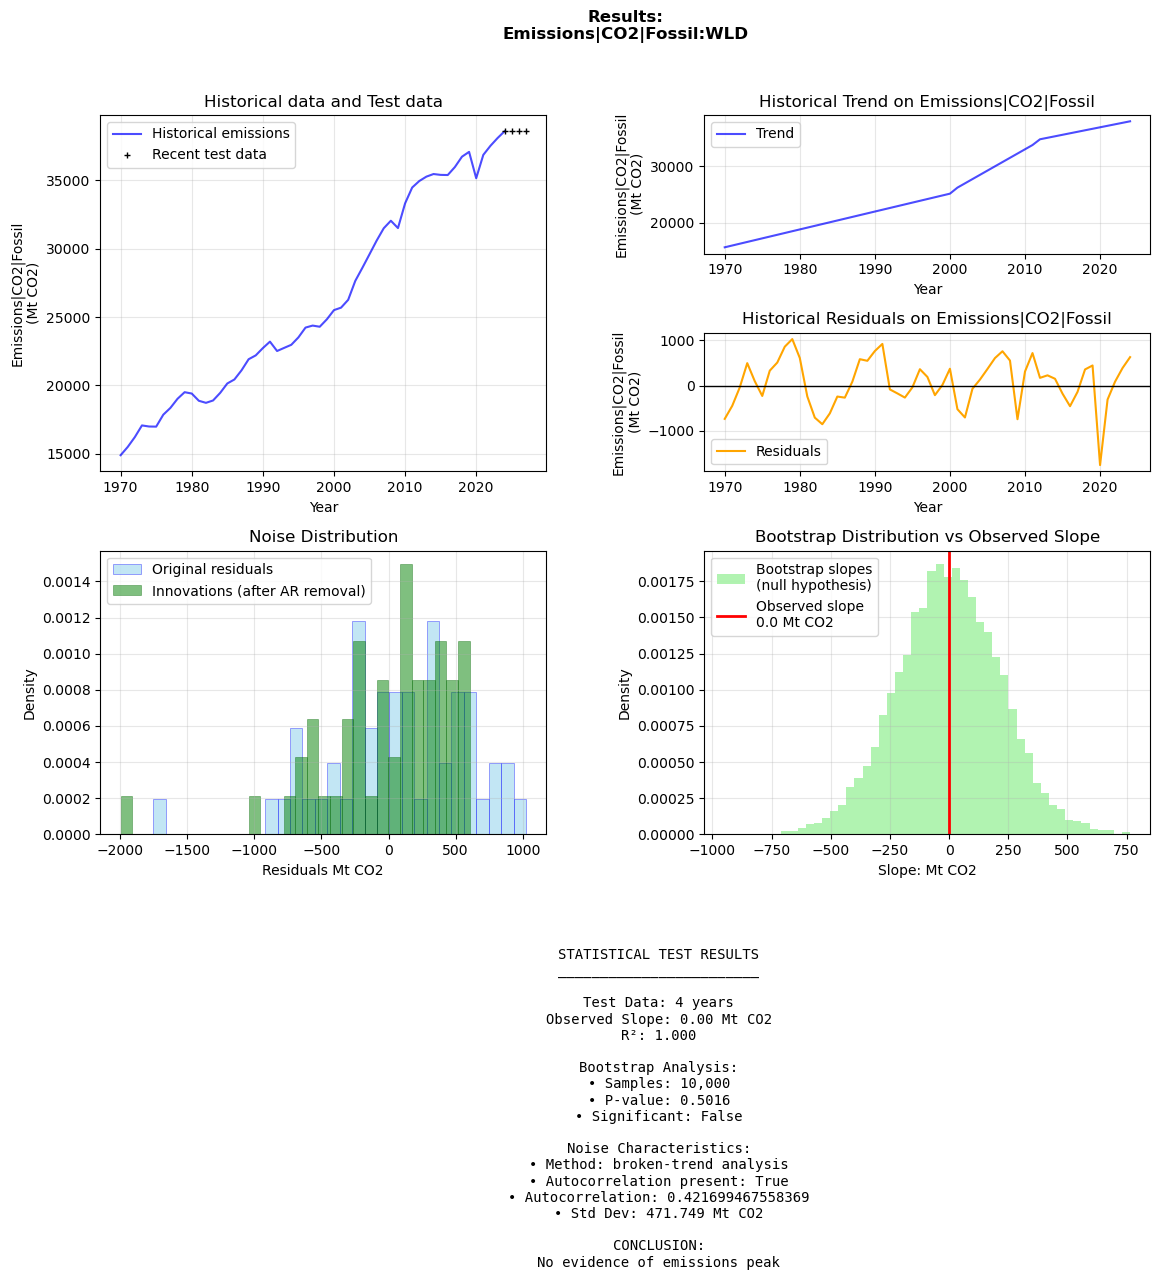

In [8]:
peak_tester.plot_analysis()

In [9]:
# Testing that with a flat trend, it gives ~50% chance that emissions have actually peaked
peak_tester.set_test_data([
        (2024, peak_tester.historical_data.iloc[-1,1]),
        (2025, peak_tester.historical_data.iloc[-1,1]*0.99),
        (2026, peak_tester.historical_data.iloc[-1,1]*0.99**2), 
        (2027, peak_tester.historical_data.iloc[-1,1]*0.99**3),
    ])

Test data set: 2024-2027
Test slope: -382.14 Mt CO2 (R² = 1.000)


In [10]:
peak_tester.characterize_noise(method='broken_trend',include_test_data=True) # choose 'normal', 't-dist' or 'empirical'. If 't-dist' can choose t_df or leave to calculate
peak_tester.create_noise_generator()
peak_tester.run_complete_bootstrap_test(bootstrap_method='ar_bootstrap')


Max breakpoints: 12
using normal distribution to calculate noise
Autocorrelation analysis:

  Lag-1 autocorr: 0.423
  Residual σ (post-autocorrelation): 478.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.9983505663660167
Noise characterization complete:
  Method used: broken_trend
Using AR(1) noise generator with φ=0.42, mean=0.000, sigma=477.971
Running complete bootstrap test...
  Null hypothesis: zero_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.0384
  Significant at α=0.1: True
  Effect size: 1.76 standard deviations


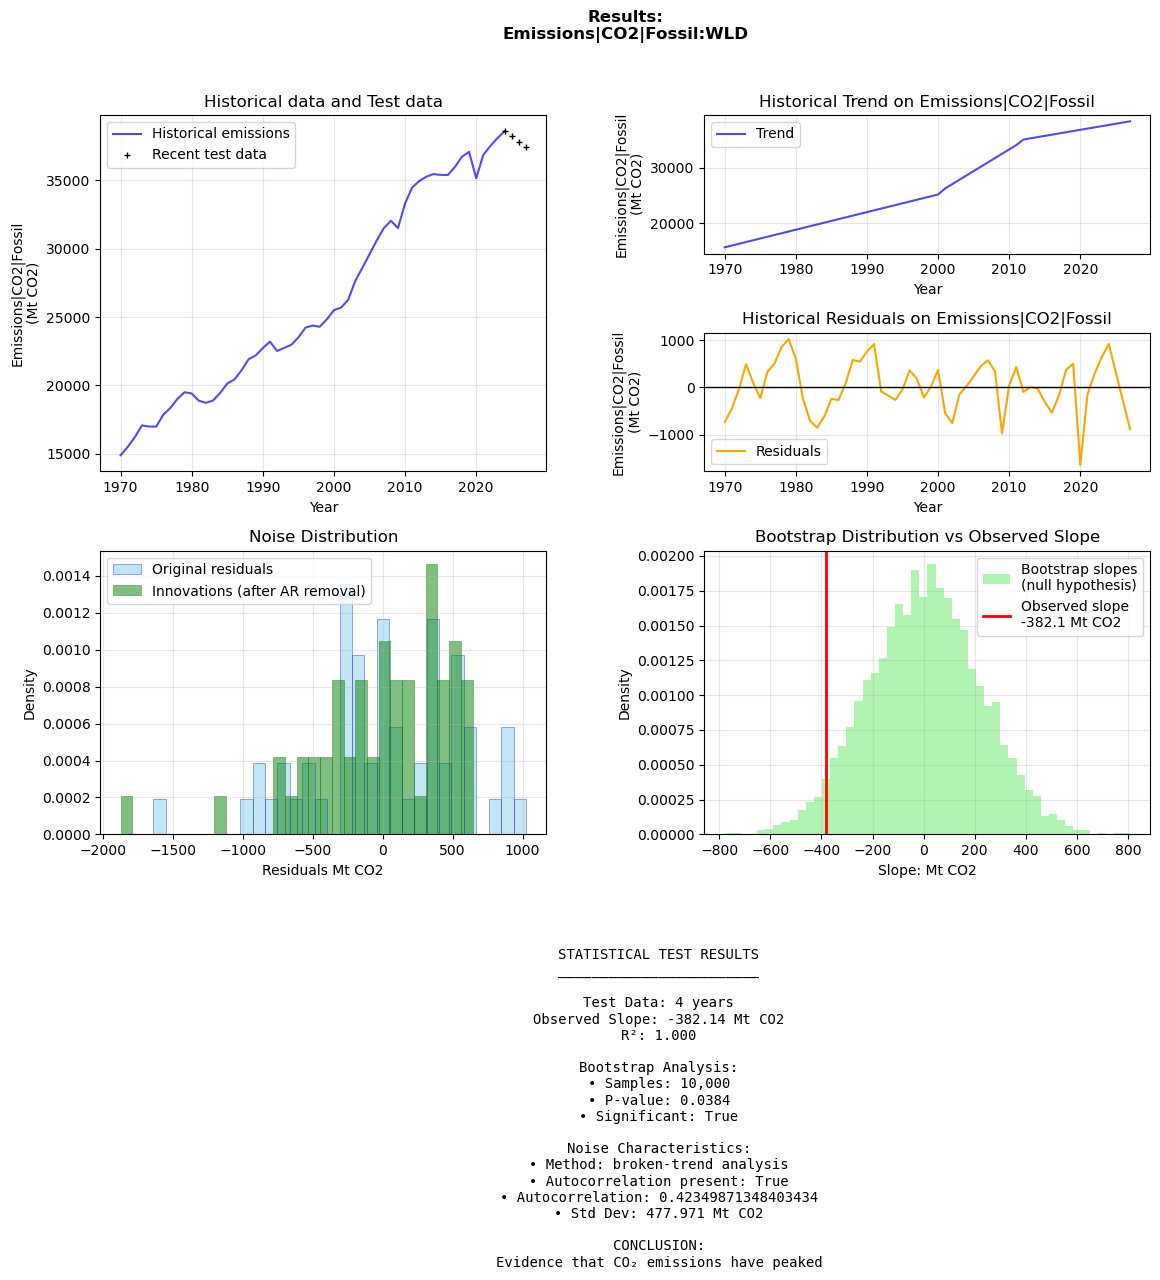

In [11]:
peak_tester.plot_analysis()

## Implementation on carbon intensity
Test applying the peak tester to carbon intensity instead, which abstracts out the GDP growth component

In [41]:
carbon_intensity_tester = EmissionsPeakTest()
carbon_intensity_tester.load_historical_data(
    'carbon_intensity_gdp.csv', region='WLD',year_range = range(1970,2025))

Loaded historical data: 1970-2024
Data points: 55


Let's assume that GDP is growing at 2% per year over a three year period. Therefore we want to test if carbon intensity is falling more than 2% per year (which would be needed to offset a GDP growth trend)

In [42]:
ci_2023 = carbon_intensity_tester.historical_data.loc[carbon_intensity_tester.historical_data.year==2023,'emissions'].squeeze()

In [33]:
ci_improvement = 0.02 # % improvements per year

carbon_intensity_tester.set_test_data([
        (2025, ci_2023*(1-ci_improvement)),
        (2026, ci_2023*(1-ci_improvement)**2), 
        (2027, ci_2023*(1-ci_improvement)**3)])

Test data set: 2025-2027
Test slope: -0.01 kg CO2 / $ (R² = 1.000)


In [61]:
carbon_intensity_tester.set_test_data([
        (2025, ci_2023-0.006),
        (2026, ci_2023 - (0.0065*2)), 
        (2027, ci_2023 - (0.0065*3))])

Test data set: 2025-2027
Test slope: -0.01 kg CO2 / $ (R² = 1.000)


In [62]:
carbon_intensity_tester.characterize_noise(method='broken_trend', include_test_data = False).create_noise_generator()

Max breakpoints: 11
using normal distribution to calculate noise
Autocorrelation analysis:

  Lag-1 autocorr: 0.660
  Residual σ (post-autocorrelation): 0.0
  Has significant autocorr: True
  Likelihood of autocorr: 0.9999990645351197
Noise characterization complete:
  Method used: broken_trend
Using AR(1) noise generator with φ=0.66, mean=-0.000, sigma=0.006


<function peak_tester.EmissionsPeakTest.create_noise_generator.<locals>.ar1_noise_generator(size: int, initial_value: float | None = 0) -> numpy.ndarray>

Running complete bootstrap test...
  Null hypothesis: recent_trend
  Bootstrap method: ar_bootstrap
  Bootstrap samples: 10000
Results:
  P-value: 0.4348
  Significant at α=0.1: False
  Effect size: 0.16 standard deviations


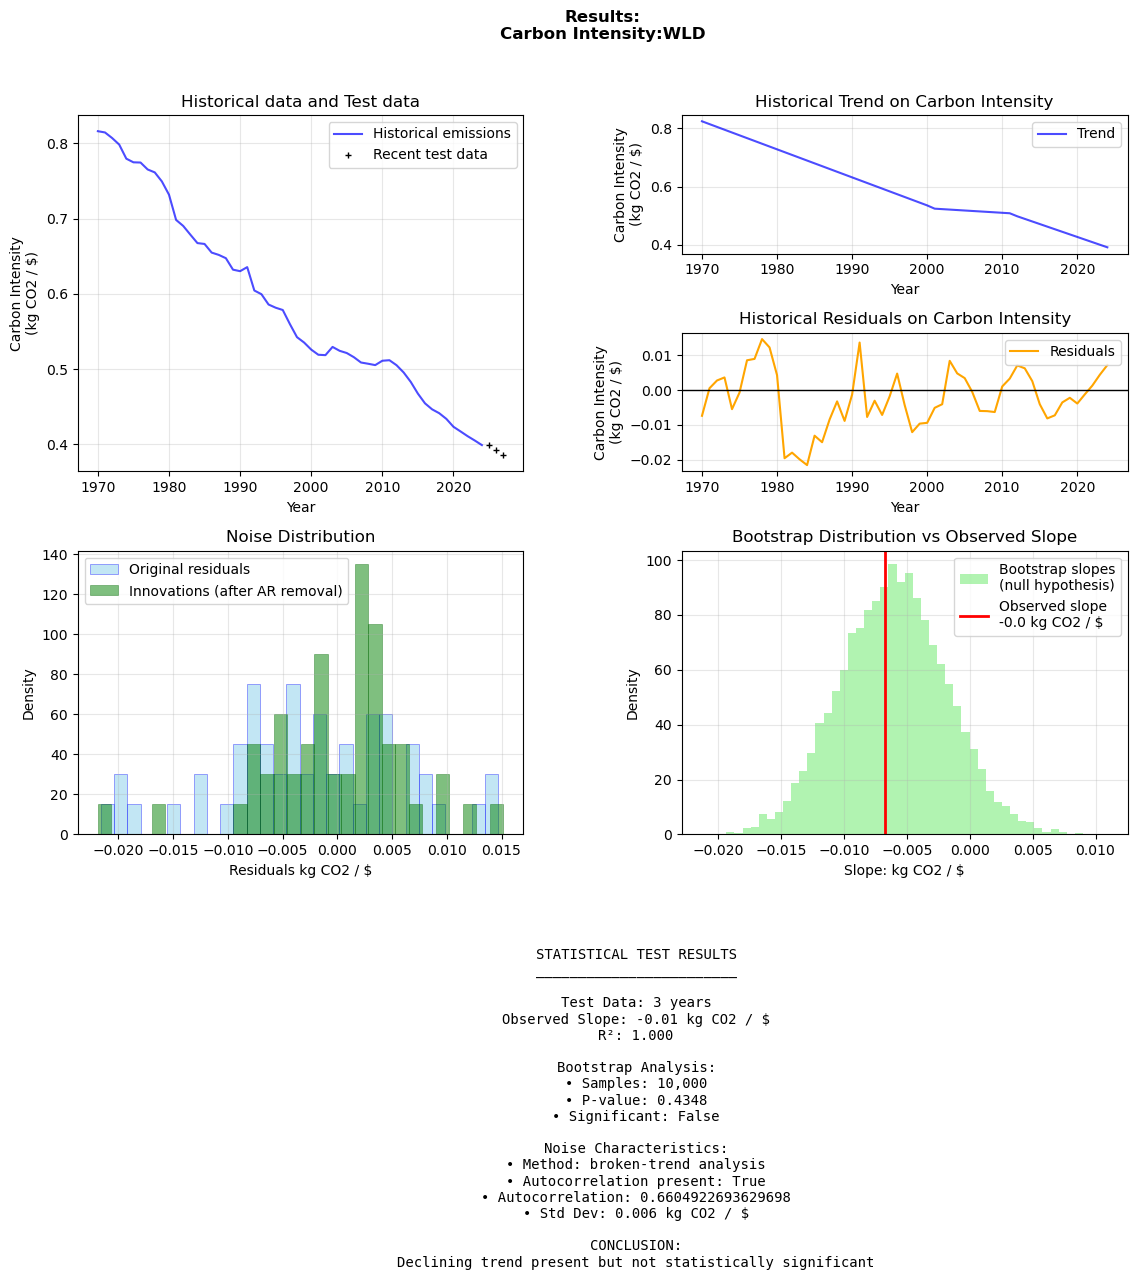

In [63]:
carbon_intensity_tester.run_complete_bootstrap_test(bootstrap_method='ar_bootstrap',null_hypothesis='recent_trend')

carbon_intensity_tester.plot_analysis()

In [40]:
carbon_intensity_tester.recent_historical_trend

np.float64(-0.006069756330775924)

In [56]:
carbon_intensity_tester.historical_data

,year,emissions
9,1970,0.816065
10,1971,0.814398
11,1972,0.807029
12,1973,0.798307
13,1974,0.779571
14,1975,0.774742
15,1976,0.774447
16,1977,0.765243
17,1978,0.761343
18,1979,0.749344


In [57]:
0.012/0.399

0.03007518796992481